# Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Importation du dataset

In [2]:
df = pd.read_csv("../movies.csv")

# Premières infos

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [4]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


# Nettoyage

In [5]:
df = df.drop(columns=['Meta_score', 'Gross'])
df = df.rename(columns={"Series_Title": "Title", "Released_Year": "Year", "IMDB_Rating": "Rating", "No_of_Votes": "Votes", "Runtime": "Duration"})

## Séparer les genres

In [6]:
# Séparer tous les genres et obtenir la liste unique
all_genres = (
    df['Genre']
    .dropna()
    .str.split(', ')
    .explode()
    .unique()
)

# Trier pour plus de lisibilité
all_genres = sorted(all_genres)

print(all_genres)

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [7]:
genre_dummies = (
    df['Genre']
    .str.get_dummies(sep=', ')
)

# Ajouter les colonnes au DataFrame original
df = pd.concat([df, genre_dummies], axis=1)
df.drop(columns=['Genre'], inplace=True)

# Statistiques descriptives

In [8]:
df['Rating'].describe()

count    1000.000000
mean        7.949300
std         0.275491
min         7.600000
25%         7.700000
50%         7.900000
75%         8.100000
max         9.300000
Name: Rating, dtype: float64

In [9]:
genre_stats = pd.DataFrame({
    'average_rating': [
        df.loc[df[genre] == 1, 'Rating'].mean()
        for genre in all_genres
    ],
    'nb_movies': df[all_genres].sum().values
}, index=all_genres)

genre_stats = genre_stats.sort_values('average_rating', ascending=False)

genre_stats

 

,average_rating,nb_movies
War,8.013725,51
Western,8.000000,20
Film-Noir,7.989474,19
Sci-Fi,7.977612,67
Mystery,7.967677,99
Drama,7.959392,724
Crime,7.954545,209
History,7.953571,56
Adventure,7.952041,196
Action,7.948677,189


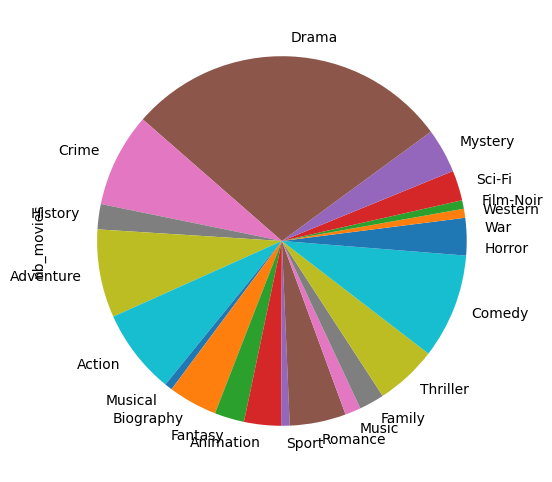

In [10]:

genre_stats.plot(
    y='nb_movies',
    kind='pie',
    legend=False,
    figsize=(8,6),
)
plt.show()


# Similarité

In [11]:
df['Overview'] = df['Overview'].fillna("").str.lower()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

tfidf_matrix = tfidf.fit_transform(df['Overview'])

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [14]:
def get_similar_movies(title, df, cosine_sim, top_n=5):
    idx = df.index[df['Title'] == title][0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:top_n+1]  # on enlève le film lui-même

    movie_indices = [i[0] for i in sim_scores]

    return df[['Title', 'Overview']].iloc[movie_indices]


In [16]:
get_similar_movies("The Godfather", df, cosine_sim)


,Title,Overview
463,Knives Out,a detective investigates the death of a patria...
974,The Godfather: Part III,"follows michael corleone, now in his 60s, as h..."
739,Nebraska,"an aging, booze-addled father makes the trip f..."
442,The Night of the Hunter,a religious fanatic marries a gullible widow w...
628,The Curious Case of Benjamin Button,"tells the story of benjamin button, a man who ..."
